In [1]:
import json
import os
import pandas as pd
from plotnine import *

In [2]:
METRICS_DIR = '/home/pmccarthy/projects/embedding_study/metrics'

In [3]:
! ls {METRICS_DIR}

 1c0a3a9ae7bde64d106dc635a0143b896139d088_add_skipgram_google_default
 2a7a13a25476442173d8d6fccad62bda88339ed1_add_skipgramv2
"51ad8085fc0d415e7bbd1a24969a9429a637f133_add_a_test_in_which_we_don't_rely_on_keras_sampling,_but_instead_perform_empirical_positive_sampling_as_Mikolov_lays_out"
 7b6ed1d57b17a7a8e7ffd6d270afd93ff245410b_add_paper-appropriate_sampling_to_google_default
 93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code
'c8e0ce636881157d4da79a124cc17d9ba290546f__*_Add_param_to_config.py_allowing_for_a_config_file_to_be_supplied_rather_than_expected__*_add_a_run_to_the_config_in_which_gensim_runs_with_defaults_except_with_a_max_vocab_of_4096.'
 e2fb120c7fb4fb6b3b377c85ad051cdd368ea573_add_param_to_limit_gensim_sequence_length


In [4]:
def read_single(obj, filename):
    df_obj = {}
    similarities = {}
    
    for k in obj.keys():
        
        if 'similarity' in k:
            similarities[k] = pd.DataFrame(obj[k])
            
    
        elif k == 'benchmarks':
            benchmarks = pd.DataFrame(obj[k]).assign(filename = filename)
            
    df_obj['similarities'] = pd.concat(similarities)
    df_obj['benchmarks'] = benchmarks
    df_obj['filename'] = filename
    return df_obj

In [5]:
metrics = {}
runs = os.listdir(METRICS_DIR)

for dirname in runs:
    print(dirname)
    metrics[dirname] = {}
    
    for file in os.listdir(os.path.join(METRICS_DIR,dirname)):
        file_path = os.path.join(METRICS_DIR,dirname,file)
        with open(file_path,'r') as f:
            file_name = ".".join(file.split('.')[:-1])
            metrics[dirname][file] = read_single(json.loads(json.load(f)), file_name)


e2fb120c7fb4fb6b3b377c85ad051cdd368ea573_add_param_to_limit_gensim_sequence_length
51ad8085fc0d415e7bbd1a24969a9429a637f133_add_a_test_in_which_we_don't_rely_on_keras_sampling,_but_instead_perform_empirical_positive_sampling_as_Mikolov_lays_out
93bebc15e98df1fc5eab83cc89ef1090f7b98c3e_add_first_pass_at_testing_code
2a7a13a25476442173d8d6fccad62bda88339ed1_add_skipgramv2
1c0a3a9ae7bde64d106dc635a0143b896139d088_add_skipgram_google_default
c8e0ce636881157d4da79a124cc17d9ba290546f__*_Add_param_to_config.py_allowing_for_a_config_file_to_be_supplied_rather_than_expected__*_add_a_run_to_the_config_in_which_gensim_runs_with_defaults_except_with_a_max_vocab_of_4096.
7b6ed1d57b17a7a8e7ffd6d270afd93ff245410b_add_paper-appropriate_sampling_to_google_default


In [6]:
metrics = {list(metrics.keys())[3]: metrics[list(metrics.keys())[3]]}

In [7]:
metrics.keys()

dict_keys(['2a7a13a25476442173d8d6fccad62bda88339ed1_add_skipgramv2'])

In [8]:
benchmarks = []

for dirname in metrics.keys():
    for file in metrics[dirname]:
        benchmarks.append(metrics[dirname][file]['benchmarks'])

benchmark_df =(
    pd.concat(benchmarks)
    .assign(metric_rank = lambda x: x.groupby(['test','metric'])['value'].rank(ascending=False))
    .sort_values('metric_rank')    
    .assign(short_name = lambda x: x['filename'].str.split('_').apply(lambda y: "_".join([z for z in y[:-1]])))
    .drop('filename',axis=1)
)
print(benchmark_df.sort_values(["short_name",'test','metric']).to_markdown())


|    | test       | metric       |      value |   metric_rank | short_name                         |
|---:|:-----------|:-------------|-----------:|--------------:|:-----------------------------------|
|  4 | google     | accuracy     | 0.0621118  |             1 | gensim_max_final_vocab_4096_len_10 |
|  2 | simlex999  | pearson_cor  | 0.14687    |             3 | gensim_max_final_vocab_4096_len_10 |
|  3 | simlex999  | spearman_cor | 0.151586   |             3 | gensim_max_final_vocab_4096_len_10 |
|  0 | wordsim353 | pearson_cor  | 0.359294   |             1 | gensim_max_final_vocab_4096_len_10 |
|  1 | wordsim353 | spearman_cor | 0.406543   |             1 | gensim_max_final_vocab_4096_len_10 |
|  4 | google     | accuracy     | 0.00722456 |             4 | google_default                     |
|  2 | simlex999  | pearson_cor  | 0.0969306  |             4 | google_default                     |
|  3 | simlex999  | spearman_cor | 0.0922134  |             4 | google_default             

/opt/conda/envs/emb/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/opt/conda/envs/emb/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


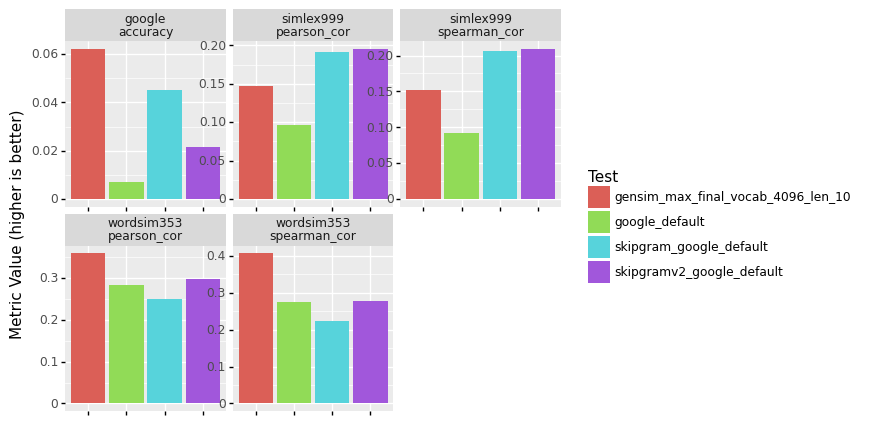

<ggplot: (8727663160077)>

In [9]:
(
    ggplot(benchmark_df, aes(x='short_name',y='value', fill='short_name'))
    + geom_bar(stat='identity')
    + facet_wrap(['test','metric'], scales='free')
    + labs(fill="Test",x="",y="Metric Value (higher is better)")
    + theme(axis_text_x=element_blank())
)

In [10]:
similarities = []
for dirname in metrics.keys():
    for file in metrics[dirname]:
        file_shortname = "_".join(file.split('_')[:-1])
        similarities.append(metrics[dirname][file]['similarities'].assign(file=file_shortname))

In [11]:
print((
    pd.concat(similarities)
    .reset_index()
    .rename(columns={'level_0':'test','level_1':'rank'})
    .query('rank <= 3')
    .drop('cosine_dist',axis=1)
    .pivot(index=['file','rank'],columns='test')
).to_markdown())

|                                           | ('word', 'boat_similarity')   | ('word', 'december_similarity')   | ('word', 'french_similarity')   | ('word', 'street_similarity')   |
|:------------------------------------------|:------------------------------|:----------------------------------|:--------------------------------|:--------------------------------|
| ('gensim_max_final_vocab_4096_len_10', 0) | race                          | march                             | russian                         | avenue                          |
| ('gensim_max_final_vocab_4096_len_10', 1) | carrier                       | april                             | german                          | junction                        |
| ('gensim_max_final_vocab_4096_len_10', 2) | battalions                    | january                           | italian                         | town                            |
| ('gensim_max_final_vocab_4096_len_10', 3) | cruiser                       | july        

In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))